In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset you chose - **Santander Customer Satisfaction**

Team members names: 

* Suraj Kumar Mondal

* Saurabh Shetty

* Vishal Kumar

* Nazim Saifi

## Add your video and report link here

### Add your code link here

# Library Imports

In [ ]:
!pip install feature_engine

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, DropCorrelatedFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error, log_loss, recall_score
from xgboost import XGBClassifier

%matplotlib inline

# Read Dataset

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/Univ.AI/train.csv')

In [ ]:
train_data.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,...,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3.00,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,195.0,0.0,0.0,195.0,0.0,0.0,195.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,91.56,138.84,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,...,40501.08,13501.47,0.0,0.0,0.0,0.0,0.0,0.0,85501.89,85501.89,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [ ]:
# Describe train dataset
train_data.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.477676,0.011458,0.003762,0.0,0.0,0.958024,0.663760,0.000105,0.000026,0.032833,0.028598,0.067522,0.045462,0.052249,0.042936,0.041476,0.010168,0.009997,0.000026,0.000026,0.050855,...,1077.256756,1048.856447,68.275452,9.505287,124.620962,110.026575,3.997023e+03,613.534443,5.703008e+03,4.401002e+03,3639.419939,556.184178,4852.261814,3857.848542,771.227449,162.170439,9.569502e+02,7.509563e+02,0.175324,0.0,0.513023,0.344174,9.117181e+01,3.646318e+01,1.310316e+02,1.092169e+02,0.213071,0.001910,0.253907,0.186630,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,95.268204,319.605516,512.154823,531.897917,950.086398,697.712596,535.473750,953.578624,712.767240,465.391149,0.106425,0.061221,0.0,0.0,0.200535,0.472425,0.010258,0.005129,0.178202,0.166674,0.250925,0.208316,0.222531,0.202714,0.199390,0.100325,0.099486,0.005129,0.005129,0.219703,...,9614.906985,8189.948852,1733.838226,519.389157,2205.249804,1935.305713,3.777314e+04,9292.752726,4.620254e+04,3.550718e+04,26359.174223,7182

# Feature Preprocessing

In [ ]:
##  Check if any null values in dataframe
train_data.isnull().sum().sum()
## No observations are Nan or None

0

In [ ]:
# Drop duplicate records
train_data = train_data.drop("ID", axis=1)
original_records = train_data.shape[0]

train_data = train_data.drop_duplicates()
print(f"Dropped {original_records - train_data.shape[0]} duplicate records")

Dropped 4807 duplicate records


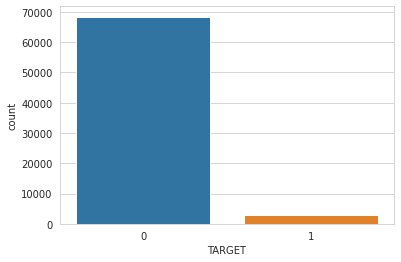

In [ ]:
# Check Distribution of observations based on TARGET columns
sns.set_style('whitegrid')
sns.countplot(x = 'TARGET', data = train_data)

In [ ]:
## Count of class 0 and 1
train_data.TARGET.value_counts()

0    68398
1     2815
Name: TARGET, dtype: int64

The dataset seems to be heavily imbalanced with 96% observations belonging to class 0 (satisfied customers)




In [ ]:
# Removing constant value features (zero variance features) from the dataset
const_col = []
for col in train_data.columns:
  if train_data[col].unique().shape[0] <= 1:
    const_col.append(col)
print(f'Removing {len(const_col)} features with constant values')
train_data = train_data.drop(const_col, axis = 1)
# train_data.shape

Removing 34 features with constant values


In [ ]:
#Spilt design matrix and target column
X = train_data.drop(['TARGET'], axis = 1)
y = train_data['TARGET']


In [ ]:
# Split train test split with 20% test data and stratified to ensure equal distribution of observations
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0, stratify = y)

In [ ]:
## Drop features that are exactly identical to each other
duplicates = DropDuplicateFeatures()

# find duplicated features in the train set
duplicates.fit(X_train)

DropDuplicateFeatures()

In [ ]:
## Columns that are exactly identical to each other
duplicates.duplicated_feature_sets_

[{'ind_var29_0', 'ind_var6_0'},
 {'ind_var29', 'ind_var6'},
 {'ind_var13_medio', 'ind_var13_medio_0'},
 {'ind_var18', 'ind_var18_0'},
 {'ind_var26', 'ind_var26_0'},
 {'ind_var25', 'ind_var25_0'},
 {'ind_var32', 'ind_var32_0'},
 {'ind_var34', 'ind_var34_0'},
 {'ind_var37', 'ind_var37_0'},
 {'ind_var39', 'ind_var40'},
 {'num_var29_0', 'num_var6_0'},
 {'num_var29', 'num_var6'},
 {'num_var13_medio', 'num_var13_medio_0'},
 {'num_var18', 'num_var18_0'},
 {'num_var26', 'num_var26_0'},
 {'num_var25', 'num_var25_0'},
 {'num_var32', 'num_var32_0'},
 {'num_var34', 'num_var34_0'},
 {'num_var37', 'num_var37_0'},
 {'num_var39', 'num_var40'},
 {'saldo_var29', 'saldo_var6'},
 {'saldo_medio_var13_medio_ult1', 'saldo_var13_medio'},
 {'delta_imp_reemb_var13_1y3', 'delta_num_reemb_var13_1y3'},
 {'delta_imp_reemb_var17_1y3', 'delta_num_reemb_var17_1y3'},
 {'delta_imp_reemb_var33_1y3', 'delta_num_reemb_var33_1y3'},
 {'delta_imp_trasp_var17_in_1y3', 'delta_num_trasp_var17_in_1y3'},
 {'delta_imp_trasp_var17_o

In [ ]:
print('Number of variables before removing duplicates: ', X_train.shape[1])

X_train = duplicates.transform(X_train)
X_test = duplicates.transform(X_test)

print('Number of variables after removing duplicates: ', X_train.shape[1])

Number of variables before removing duplicates:  335
Number of variables after removing duplicates:  306


In [ ]:
# Identify categorical columns based on unique values. All categorical features would have value as [0,1] only
i= 0 
categorical_columns =[]
for col in X_train.columns:
  uniques = X_train[col].unique()
  if all([unique in [0,1] for unique in uniques]):
    i+=1
    categorical_columns.append(col)
    # print(f"{i} : {col} -- {uniques}")
len(categorical_columns)

56

In [ ]:
categorical_columns

['ind_var1_0',
 'ind_var1',
 'ind_var5_0',
 'ind_var5',
 'ind_var6_0',
 'ind_var6',
 'ind_var8_0',
 'ind_var8',
 'ind_var12_0',
 'ind_var12',
 'ind_var13_0',
 'ind_var13_corto_0',
 'ind_var13_corto',
 'ind_var13_largo_0',
 'ind_var13_largo',
 'ind_var13_medio_0',
 'ind_var13',
 'ind_var14_0',
 'ind_var14',
 'ind_var17_0',
 'ind_var17',
 'ind_var18_0',
 'ind_var19',
 'ind_var20_0',
 'ind_var20',
 'ind_var24_0',
 'ind_var24',
 'ind_var25_cte',
 'ind_var26_0',
 'ind_var26_cte',
 'ind_var25_0',
 'ind_var30_0',
 'ind_var30',
 'ind_var31_0',
 'ind_var31',
 'ind_var32_cte',
 'ind_var32_0',
 'ind_var33_0',
 'ind_var33',
 'ind_var34_0',
 'ind_var37_cte',
 'ind_var37_0',
 'ind_var39_0',
 'ind_var40_0',
 'ind_var40',
 'ind_var41_0',
 'ind_var44_0',
 'ind_var44',
 'ind_var7_emit_ult1',
 'ind_var7_recib_ult1',
 'ind_var10_ult1',
 'ind_var10cte_ult1',
 'ind_var9_cte_ult1',
 'ind_var9_ult1',
 'ind_var43_emit_ult1',
 'ind_var43_recib_ult1']

Drop highly  corelated features

In [ ]:
#Separate categorical and numeric features for correlation and scaling
X_train_cat = X_train[categorical_columns]
X_test_cat = X_test[categorical_columns]

X_train_num = X_train.drop(categorical_columns, axis=1)
X_test_num = X_test.drop(categorical_columns, axis=1)

In [ ]:
#Remove features with >95% correlation in numerical dataset
correlated = DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.95)

# find correlated variables in the train set
correlated.fit(X_train_num)

DropCorrelatedFeatures(threshold=0.95)

In [ ]:
# Correlated columns that will be dropped
len(correlated.features_to_drop_)


62

In [ ]:
print('Number of variables before removing correlated: ', X_train_num.shape[1])

X_train_num = correlated.transform(X_train_num)
X_test_num = correlated.transform(X_test_num)

print('Number of variables after removing correlated: ', X_train_num.shape[1])

Number of variables before removing correlated:  250
Number of variables after removing correlated:  188


In [ ]:
#Scale Numerical data
scaler = StandardScaler()

scaled_train_num = scaler.fit_transform(X_train_num)
X_train_num = pd.DataFrame(scaled_train_num, columns=X_train_num.columns)

scaled_test_num = scaler.transform(X_test_num)
X_test_num = pd.DataFrame(scaled_test_num, columns=X_test_num.columns)


In [ ]:
X_train_cat.shape, X_train_num.shape, X_test_num.shape, X_test_cat.shape

((56970, 56), (56970, 188), (14243, 188), (14243, 56))

In [ ]:
# Join Categorical and numeric features
X_train = pd.concat([X_train_cat.reset_index(drop=True), X_train_num.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test_cat.reset_index(drop=True), X_test_num.reset_index(drop=True)], axis=1)


In [ ]:
X_train.shape, X_test.shape


((56970, 244), (14243, 244))

In [ ]:
## Drop Sparse Columns. ie. columns having 0 in more than 99% of the observations
i=0
sparse_columns = []
for col in X_train.columns: #removing all sparse features
    if np.percentile(X_train[col],99)==0:
      sparse_columns.append(col)
X_train = X_train.drop(sparse_columns, axis=1)
X_test = X_test.drop(sparse_columns, axis=1)

print(f"dropped {len(sparse_columns)} sparse columns")

dropped 23 sparse columns


In [ ]:
X_train.shape, X_test.shape

((56970, 221), (14243, 221))

In [ ]:
X_train.head()

,ind_var1_0,ind_var5_0,ind_var5,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13,ind_var14_0,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var25_0,ind_var30_0,ind_var30,ind_var37_cte,ind_var37_0,ind_var39_0,ind_var40_0,ind_var41_0,ind_var10_ult1,ind_var10cte_ult1,ind_var9_cte_ult1,ind_var9_ult1,ind_var43_emit_ult1,ind_var43_recib_ult1,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,...,num_op_var40_efect_ult3,num_op_var41_efect_ult1,num_op_var41_efect_ult3,num_reemb_var17_ult1,num_sal_var16_ult1,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_trasp_var33_in_ult1,num_venta_var44_hace3,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,var38
0,0,1,1,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0.038177,0.948729,-0.055951,-0.220722,-0.228155,-0.03885,-0.04307,...,-0.018317,-0.231038,-0.241711,-0.011535,-0.032153,-0.179609,-0.233298,-0.105309,-0.007918,-0.006842,-0.018727,0.423116,-0.106361,-0.311344,1.164722,-0.106132,-0.106680,0.523089,-0.040271,-0.018781,-0.056987,-0.058314,-0.109909,-0.068533,4.034075,-0.078494,-0.06099,-0.035405,-0.06054,-0.019523,-0.009085,-0.005885,-0.00419,-0.005632,-0.018802,-0.013131,-0.016772,-0.013227,-0.019863,0.175427
1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,1,0,1,1,1,1,1,0,0,0.038177,0.643833,-0.055951,0.130528,-0.009083,-0.03885,-0.04307,...,-0.018317,-0.231038,-0.241711,-0.011535,-0.032153,-0.179609,-0.233298,-0.105309,-0.007918,-0.006842,-0.018727,-0.385319,0.451954,0.495721,-0.133746,-0.106883,-0.112608,-0.133439,-0.002306,-0.018781,0.063338,0.028253,-0.109909,-0.068533,-0.142179,-0.078494,-0.06099,-0.035405,-0.06054,-0.019523,-0.009085,-0.005885,-0.00419,-0.005632,-0.018802,-0.013131,-0.016772,-0.013227,-0.019863,-0.366848
2,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0.038177,0.034041,-0.055951,-0.220722,-0.228155,-0.03885,-0.04307,...,-0.018317,-0.231038,-0.241711,-0.011535,-0.032153,-0.179609,-0.233298,-0.105309,-0.007918,-0.006842,-0.018727,-0.385319,0.451954,-0.311344,-0.133503,-0.106890,-0.112312,-0.133098,-0.040271,-0.018781,-0.056987,-0.058314,-0.109909,-0.068533,-0.142179,-0.078494,-0.06099,-0.035405,-0.06054,-0.019523,-0.009085,-0.005885,-0.00419,-0.005632,-0.018802,-0.013131,-0.016772,-0.013227,-0.019863,-0.170115
3,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0.038177,-0.575751,-0.055951,-0.220722,-0.228155,-0.03885,-0.04307,...,-0.018317,-0.231038,-0.241711,-0.011535,-0.032153,-0.179609,-0.233298,-0.105309,-0.007918,-0.006842,-0.018727,-0.183210,-0.385518,-0.311344,-0.124024,-0.102696,-0.100752,-0.122071,-0.040271,-0.018781,-0.056987,-0.058314,-0.109909,-0.068533,-0.142179,-0.078494,-0.06099,-0.035405,-0.06054,-0.019523,-0.009085,-0.005885,-0.00419,-0.005632,-0.018802,-0.013131,-0.016772,-0.013227,-0.019863,-0.323239
4,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0.038177,-0.423303,-0.055951,-0.220722,-0.228155,-0.03885,-0.04307,...,-0.018317,-0.231038,-0.241711,-0.011535,-0.032153,-0.179609,-0.233298,-0.105309,-0.007918,-0.006842,-0.018727,0.018898,-0.385518,-0.311344,-0.133503,-0.107035,-0.112312,-0.133149,-0.040271,-0.018781,-0.056987,-0.058314,-0.109909,-0.068533,-0.142179,-0.

In [ ]:
## Oversampling using SMOTE
oversample = SMOTE()
X_over, y_over = oversample.fit_resample(X_train, y_train)

In [ ]:
# ## Using SMOTETomek
# from imblearn.combine import SMOTETomek
# oversample = SMOTETomek()
# X_over, y_over = oversample.fit_resample(X_train, y_train)

In [ ]:
X_over.shape, y_over.shape


((109436, 221), (109436,))

In [ ]:
y_over.value_counts()

0    54718
1    54718
Name: TARGET, dtype: int64

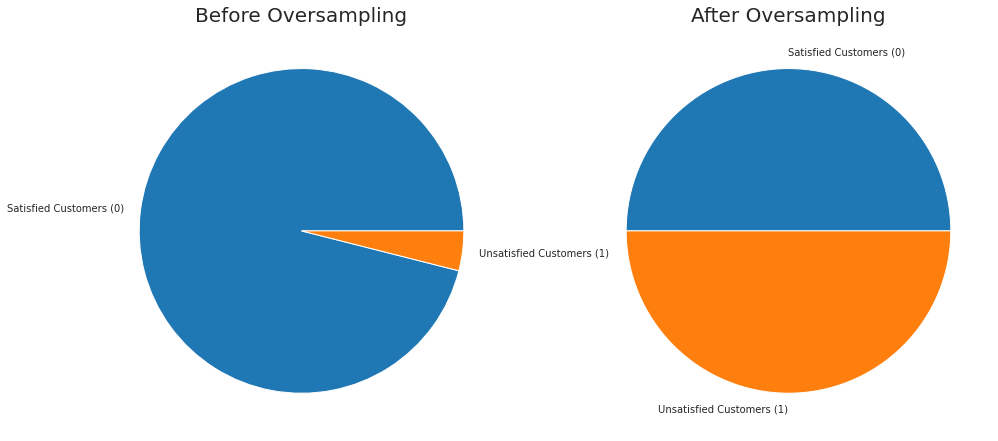

In [ ]:
# plt.rc('font', size=20)
fig, ax = plt.subplots(1,2, figsize=(16,10))
ax[0].pie(y_train.value_counts(), labels = ["Satisfied Customers (0)", "Unsatisfied Customers (1)"])
ax[0].set_title("Before Oversampling", fontsize=20)

ax[1].pie(y_over.value_counts(), labels = ["Satisfied Customers (0)", "Unsatisfied Customers (1)"])
ax[1].set_title("After Oversampling", fontsize=20)
plt.savefig("SMOTE.png",dpi=500)
plt.show()

# Model Creation

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_auc_score, classification_report, f1_score, recall_score, roc_curve, auc

## Logistic Regression

In [ ]:
#Fit LR Model on oversampled data
o_log_model = LogisticRegression(random_state = 0, max_iter = 10000)
o_log_model.fit(X_over, y_over)

LogisticRegression(max_iter=10000, random_state=0)

In [ ]:
y_pred = o_log_model.predict(X_test)
o_log_model_accuracy = accuracy_score(y_test, y_pred)
o_log_model_auc = roc_auc_score(y_test, o_log_model.predict_proba(X_test)[:,1])
o_log_model_recall = recall_score(y_test, y_pred)
o_log_model_f1 = f1_score(y_test, y_pred)

print(f'''Logistic Regression model trained using oversampled data 
accuracy = {o_log_model_accuracy:.3f}
auc_score = {o_log_model_auc:.3f}
recall = {o_log_model_recall:.3f}
f1 = {o_log_model_f1:.3f}''')

Logistic Regression model trained using oversampled data 
accuracy = 0.723
auc_score = 0.778
recall = 0.721
f1 = 0.171


In [ ]:
#Classification report on train dataset
print(classification_report(y_over, o_log_model.predict(X_over)))


              precision    recall  f1-score   support

           0       0.76      0.72      0.74     54718
           1       0.73      0.77      0.75     54718

    accuracy                           0.75    109436
   macro avg       0.75      0.75      0.75    109436
weighted avg       0.75      0.75      0.75    109436



In [ ]:
#Classification report on test dataset
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.72      0.83     13680
           1       0.10      0.72      0.17       563

    accuracy                           0.72     14243
   macro avg       0.54      0.72      0.50     14243
weighted avg       0.95      0.72      0.81     14243



In [ ]:
#Fit LR Model on imbalanced data
log_model = LogisticRegression(random_state = 0, max_iter = 10000)
log_model.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=0)

In [ ]:
y_pred = log_model.predict(X_test)
log_model_accuracy = accuracy_score(y_test, y_pred)
log_model_auc = roc_auc_score(y_test, log_model.predict_proba(X_test)[:,1])
log_model_recall = recall_score(y_test, y_pred)
log_model_f1 = f1_score(y_test, y_pred)

print(f'''Logistic Regression model trained on imbalanced data 
accuracy = {log_model_accuracy:.3f}
auc_score = {log_model_auc:.3f}
recall = {log_model_recall:.3f}
f1 = {log_model_f1:.3f}''')

Logistic Regression model trained on imbalanced data 
accuracy = 0.960
auc_score = 0.793
recall = 0.005
f1 = 0.010


It can be seen here that the Logistic Regression model trained on imbalanced data has a higher accuracy but has a very poor recall and f1-score when compared to the same LR model trained using oversampled data.

In [ ]:
#Classification report on train dataset
print(classification_report(y_test, o_log_model.predict(X_test)))


              precision    recall  f1-score   support

           0       0.98      0.72      0.83     13680
           1       0.10      0.72      0.17       563

    accuracy                           0.72     14243
   macro avg       0.54      0.72      0.50     14243
weighted avg       0.95      0.72      0.81     14243



In [ ]:
#Classification report on test dataset
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     13680
           1       0.21      0.01      0.01       563

    accuracy                           0.96     14243
   macro avg       0.59      0.50      0.49     14243
weighted avg       0.93      0.96      0.94     14243



In [ ]:
# for i in o_log_model.coef_.ravel():
#   if abs(i)>0.1:
#     print(i)

## Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tqdm import tqdm

### Hyperparameter Tuning Random Forest Classifier

In [ ]:
# TAKES A VERY LONG TIME AND FREQUENTLY CRASHES DUE TO RAM

# # Grid Search for best min_samples_split and min_samples_leaf
# rf = BalancedRandomForestClassifier(n_jobs=-1,
#                             n_estimators=best_n_estimators,
#                             oob_score=True,
#                             max_features = 'sqrt',
#                             random_state=24)

# param_grid = {
#     'min_samples_split': [2,5,10,20],
#     "min_samples_leaf": [5,10,20,30,50]
#     }

# scoring = {'AUC': 'roc_auc',
#            'RECALL':'recall',
#            "F1":'f1'}

# grid_search = GridSearchCV(rf, 
#                             param_grid, 
#                             scoring=scoring, 
#                             refit='F1', 
#                             return_train_score=True, 
#                             n_jobs=-1,
#                            verbose=2)

# results = grid_search.fit(X_over, y_over)

In [ ]:
## Takes ~30 mins to run
# Find best number of estimators for Random Forest
from collections import OrderedDict
clf = BalancedRandomForestClassifier(warm_start=True, 
                              oob_score=True,
                              min_samples_leaf=40,
                              max_depth = 10,
                              n_jobs=-1,
                              random_state=24)

error_rate = {}

# Range of `n_estimators` values to explore.
# min_estimators = 300
# max_estimators = 500
estimators = [800, 900, 1000, 1100, 1500, 2000]
for i in tqdm(estimators):
    clf.set_params(n_estimators=i) 
    clf.fit(X_over, y_over)

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - clf.oob_score_
    error_rate[i] = oob_error
    

100%|██████████| 6/6 [30:00<00:00, 300.10s/it]


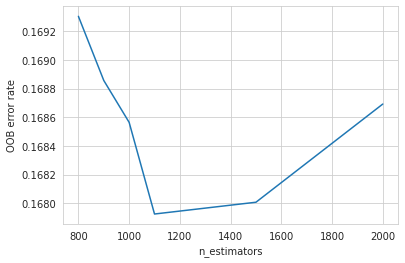

In [ ]:
xs = []
ys = []
for label, clf_err in error_rate.items():
    xs.append(label)
    ys.append(clf_err)   
plt.plot(xs, ys)
# plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show();


In [ ]:
best_n_estimators = min(error_rate, key=error_rate.get)
best_n_estimators

1100

In [ ]:
# Takes ~1hr
# Find best max_depth for best_estimator of Random Forest
from collections import OrderedDict
clf = BalancedRandomForestClassifier( 
                              oob_score=True,
                              n_estimators = best_n_estimators,
                              n_jobs=-1,
                              random_state=24)

error_rate = {}
recall_scores = []
f1_scores = []

depths = [5,8,10,15,20,30,50,100]
for i in tqdm(depths):
    clf.set_params(max_depth=i) 
    clf.fit(X_over, y_over)
    y_pred = clf.predict(X_test)
    recall_scores.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

    # Record the OOB error for each `n_estimators=i` setting.
    oob_error = 1 - clf.oob_score_
    error_rate[i] = oob_error
    print(oob_error)
    

 12%|█▎        | 1/8 [06:13<43:34, 373.50s/it]

0.25311597646112793


 25%|██▌       | 2/8 [12:46<38:28, 384.68s/it]

0.18598084725318909


 38%|███▊      | 3/8 [20:55<36:02, 432.41s/it]

0.15774516612449285


 50%|█████     | 4/8 [28:16<29:04, 436.02s/it]

0.1148342410175811


 62%|██████▎   | 5/8 [35:50<22:07, 442.59s/it]

0.09390876859534336


 75%|███████▌  | 6/8 [45:06<16:02, 481.08s/it]

0.06439380094301694


 88%|████████▊ | 7/8 [55:58<08:56, 536.74s/it]

0.05494535618991925


100%|██████████| 8/8 [1:10:53<00:00, 531.70s/it]

0.05686428597536464


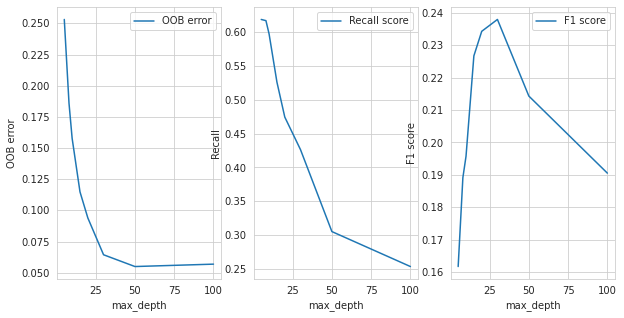

In [ ]:
xs = []
ys = []
for label, clf_err in error_rate.items():
    xs.append(label)
    ys.append(clf_err)  
fig, ax = plt.subplots(1,3, figsize=(10,5)) 
ax[0].plot(xs, ys, label="OOB error")
ax[0].set_ylabel("OOB error")
ax[0].set_xlabel("max_depth")
ax[0].legend()

ax[1].plot(xs, recall_scores, label="Recall score")
ax[1].set_ylabel("Recall")
ax[1].set_xlabel("max_depth")
ax[1].legend()

ax[2].plot(xs, f1_scores, label="F1 score")
ax[2].set_ylabel("F1 score")
ax[2].set_xlabel("max_depth")
ax[2].legend()

# plt.xlim(min_estimators, max_estimators)
plt.show();


In [ ]:
# We will choose the max_depth as 30 as he f1 score is highest for it and the OOB error is very close to minima
best_max_depth = 30

### Train Random Forest Model

In [ ]:
# From hyperparameter tuning
best_n_estimators = 1100
best_max_depth = 30

rf_model = BalancedRandomForestClassifier( 
                              n_estimators = best_n_estimators,
                              max_depth = best_max_depth,
                              n_jobs=-1,
                              random_state=24)
rf_model.fit(X_over, y_over)

BalancedRandomForestClassifier(max_depth=30, n_estimators=1100, n_jobs=-1,
                               random_state=24)

In [ ]:
y_pred = rf_model.predict(X_test)
rf_model_accuracy = accuracy_score(y_test, y_pred)
rf_model_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:,1])
rf_model_recall = recall_score(y_test, y_pred)
rf_model_f1 = f1_score(y_test, y_pred)

print(f'''Random Forest Model 
accuracy = {rf_model_accuracy:.3f}
auc_score = {rf_model_auc:.3f}
recall = {rf_model_recall:.3f}
f1 = {rf_model_f1:.3f}''')

Random Forest Model 
accuracy = 0.891
auc_score = 0.803
recall = 0.426
f1 = 0.236


In [ ]:
#Classification report on train dataset
print(classification_report(y_over, rf_model.predict(X_over)))


              precision    recall  f1-score   support

           0       0.98      0.92      0.95     54718
           1       0.93      0.98      0.95     54718

    accuracy                           0.95    109436
   macro avg       0.95      0.95      0.95    109436
weighted avg       0.95      0.95      0.95    109436



In [ ]:
#Classification report on test dataset
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.91      0.94     13680
           1       0.16      0.43      0.24       563

    accuracy                           0.89     14243
   macro avg       0.57      0.67      0.59     14243
weighted avg       0.94      0.89      0.91     14243



### Feature Importance using Permutation Importance

In [ ]:
from sklearn.inspection import permutation_importance

In [ ]:
%%time
perm_importance = permutation_importance(rf_model, X_test, y_test)

CPU times: user 2h 7min 27s, sys: 2min 11s, total: 2h 9min 39s
Wall time: 1h 13min 52s


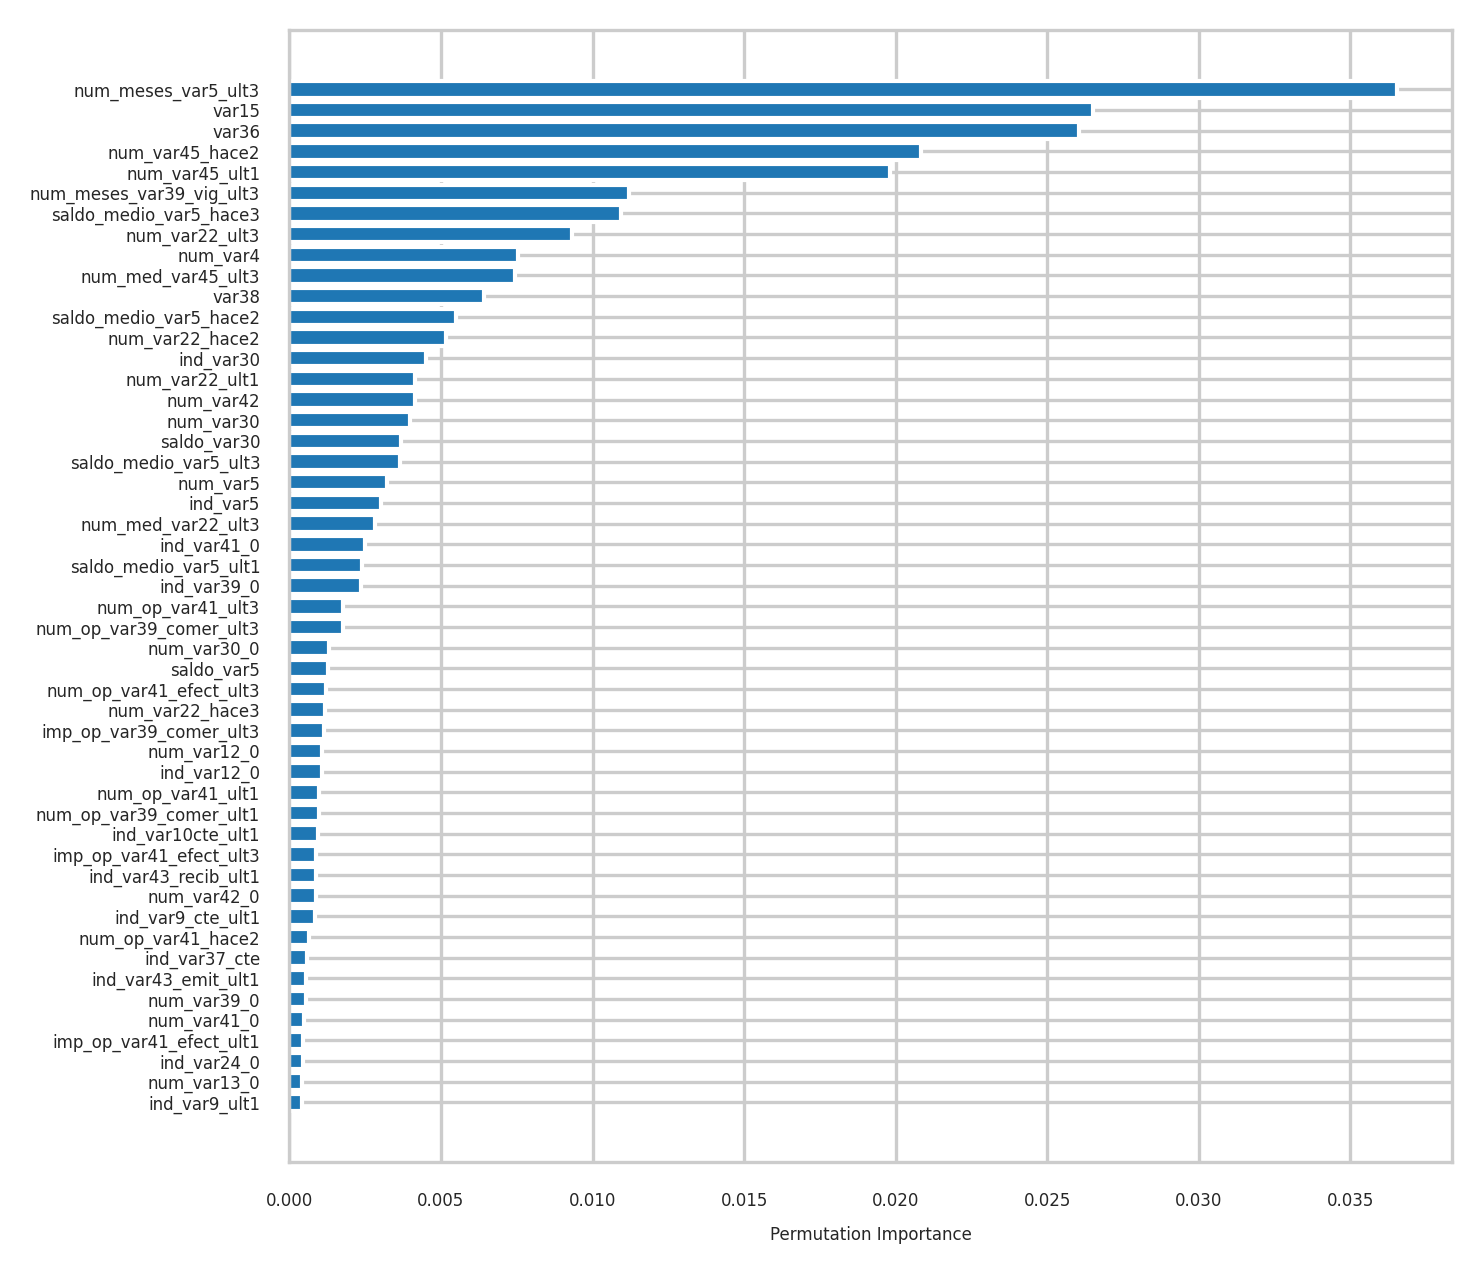

In [ ]:
plt.rc('font', size=4)
plt.figure(figsize=(5,5), dpi=300)
sorted_idx = np.absolute(perm_importance.importances_mean).argsort()[-50:]
plt.barh(X_test.columns[sorted_idx], np.absolute(perm_importance.importances_mean[sorted_idx]))
plt.xlabel("Permutation Importance")
plt.savefig("Permutation Importance.png")
plt.show()

In [ ]:
X_test.columns[sorted_idx]

Index(['ind_var9_ult1', 'num_var13_0', 'ind_var24_0',
       'imp_op_var41_efect_ult1', 'num_var41_0', 'num_var39_0',
       'ind_var43_emit_ult1', 'ind_var37_cte', 'num_op_var41_hace2',
       'ind_var9_cte_ult1', 'num_var42_0', 'ind_var43_recib_ult1',
       'imp_op_var41_efect_ult3', 'ind_var10cte_ult1',
       'num_op_var39_comer_ult1', 'num_op_var41_ult1', 'ind_var12_0',
       'num_var12_0', 'imp_op_var39_comer_ult3', 'num_var22_hace3',
       'num_op_var41_efect_ult3', 'saldo_var5', 'num_var30_0',
       'num_op_var39_comer_ult3', 'num_op_var41_ult3', 'ind_var39_0',
       'saldo_medio_var5_ult1', 'ind_var41_0', 'num_med_var22_ult3',
       'ind_var5', 'num_var5', 'saldo_medio_var5_ult3', 'saldo_var30',
       'num_var30', 'num_var42', 'num_var22_ult1', 'ind_var30',
       'num_var22_hace2', 'saldo_medio_var5_hace2', 'var38',
       'num_med_var45_ult3', 'num_var4', 'num_var22_ult3',
       'saldo_medio_var5_hace3', 'num_meses_var39_vig_ult3', 'num_var45_ult1',
       'num_var45

# XGBoost Classifier

## Train XGBoost Model

In [ ]:
XGB_clf = XGBClassifier(random_state=2022, max_depth = 10, sub_sample = 0.4, gamma = 10)
XGB_clf.fit(X_over, y_over)

XGBClassifier(gamma=10, max_depth=10, random_state=2022, sub_sample=0.4)

In [ ]:
y_pred = XGB_clf.predict(X_test)
xgb_model_accuracy = accuracy_score(y_test, y_pred)
xgb_model_auc = roc_auc_score(y_test, XGB_clf.predict_proba(X_test)[:,1])
xgb_model_recall = recall_score(y_test, y_pred)
xgb_model_f1 = f1_score(y_test, y_pred)

print(f'''XGBoost Model 
accuracy = {xgb_model_accuracy:.3f}
auc_score = {xgb_model_auc:.3f}
recall = {xgb_model_recall:.3f}
f1 = {xgb_model_f1:.3f}''')

XGBoost Model 
accuracy = 0.899
auc_score = 0.811
recall = 0.403
f1 = 0.241


In [ ]:
#Classification report on train dataset
print(classification_report(y_over, XGB_clf.predict(X_over)))


              precision    recall  f1-score   support

           0       0.95      0.92      0.94     54718
           1       0.93      0.95      0.94     54718

    accuracy                           0.94    109436
   macro avg       0.94      0.94      0.94    109436
weighted avg       0.94      0.94      0.94    109436



In [ ]:
#Classification report on test dataset
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.97      0.92      0.95     13680
           1       0.17      0.40      0.24       563

    accuracy                           0.90     14243
   macro avg       0.57      0.66      0.59     14243
weighted avg       0.94      0.90      0.92     14243



# Experiment

## Using only top 50 features for model creation

In [ ]:
sorted_idx = np.absolute(perm_importance.importances_mean).argsort()[-50:]
top_50_features = X_test.columns[sorted_idx]

In [ ]:
# top_50_features = ['ind_var37_cte', 'ind_var9_ult1', 'imp_op_var41_efect_ult3',
#        'ind_var13', 'ind_var13_0', 'num_op_var41_hace2',
#        'ind_var43_recib_ult1', 'num_var41_0', 'num_var13_0',
#        'ind_var10cte_ult1', 'ind_var43_emit_ult1', 'num_var22_hace3',
#        'num_var45_hace3', 'ind_var9_cte_ult1', 'num_op_var41_efect_ult3',
#        'num_op_var39_comer_ult1', 'num_var42_0', 'num_var12_0', 'ind_var12_0',
#        'imp_op_var39_comer_ult3', 'saldo_medio_var5_ult1', 'num_var30_0',
#        'num_var39_0', 'num_op_var41_ult3', 'num_op_var39_comer_ult3',
#        'ind_var41_0', 'ind_var39_0', 'saldo_var5', 'ind_var5',
#        'num_med_var22_ult3', 'saldo_medio_var5_ult3', 'num_var5',
#        'saldo_var30', 'num_var22_ult1', 'ind_var30', 'saldo_medio_var5_hace2',
#        'num_var42', 'num_var30', 'num_var22_hace2', 'var38',
#        'num_med_var45_ult3', 'num_var4', 'num_meses_var39_vig_ult3',
#        'num_var22_ult3', 'saldo_medio_var5_hace3', 'num_var45_ult1',
#        'num_var45_hace2', 'var15', 'var36', 'num_meses_var5_ult3']

In [ ]:
X_over_top = X_over[top_50_features]
X_test_top = X_test[top_50_features]

### Training Logistic Regression Model

In [ ]:
#Fit LR Model on oversampled data
top_log_model = LogisticRegression(random_state = 0, max_iter = 10000)
top_log_model.fit(X_over_top, y_over)

LogisticRegression(max_iter=10000, random_state=0)

In [ ]:
y_pred = top_log_model.predict(X_test_top)
top_log_model_accuracy = accuracy_score(y_test, y_pred)
top_log_model_auc = roc_auc_score(y_test, top_log_model.predict_proba(X_test_top)[:,1])
top_log_model_recall = recall_score(y_test, y_pred)
top_log_model_f1 = f1_score(y_test, y_pred)

print(f'''Logistic Regression model trained using oversampled data 
accuracy = {top_log_model_accuracy:.3f}
auc_score = {top_log_model_auc:.3f}
recall = {top_log_model_recall:.3f}
f1 = {top_log_model_f1:.3f}''')

Logistic Regression model trained using oversampled data 
accuracy = 0.712
auc_score = 0.780
recall = 0.739
f1 = 0.169


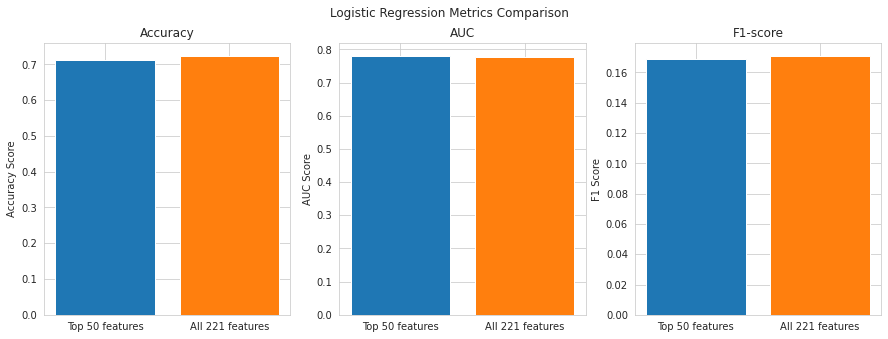

In [ ]:
plt.rc('font', size=10)
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].bar("Top 50 features", top_log_model_accuracy)
ax[0].bar("All 221 features", o_log_model_accuracy)
ax[0].set_ylabel("Accuracy Score")
ax[0].set_title("Accuracy")

ax[1].bar("Top 50 features", top_log_model_auc)
ax[1].bar("All 221 features", o_log_model_auc)
ax[1].set_ylabel("AUC Score")
ax[1].set_title("AUC")

ax[2].bar("Top 50 features", top_log_model_f1)
ax[2].bar("All 221 features", o_log_model_f1)
ax[2].set_ylabel("F1 Score")
ax[2].set_title("F1-score")
plt.suptitle("Logistic Regression Metrics Comparison")
plt.savefig("LogisticRegressionMetricsComparison.png")
plt.show()

### Training XGBoost classifier on top features

In [ ]:
top_XGB_clf = XGBClassifier(random_state=2022, max_depth = 10, sub_sample = 0.4, gamma = 10)
top_XGB_clf.fit(X_over_top, y_over)

XGBClassifier(gamma=10, max_depth=10, random_state=2022, sub_sample=0.4)

In [ ]:
y_pred = top_XGB_clf.predict(X_test_top)
top_xgb_model_accuracy = accuracy_score(y_test, y_pred)
top_xgb_model_auc = roc_auc_score(y_test, top_XGB_clf.predict_proba(X_test_top)[:,1])
top_xgb_model_recall = recall_score(y_test, y_pred)
top_xgb_model_f1 = f1_score(y_test, y_pred)

print(f'''XGBoost Model 
accuracy = {top_xgb_model_accuracy:.3f}
auc_score = {top_xgb_model_auc:.3f}
recall = {top_xgb_model_recall:.3f}
f1 = {top_xgb_model_f1:.3f}''')

XGBoost Model 
accuracy = 0.896
auc_score = 0.810
recall = 0.417
f1 = 0.240


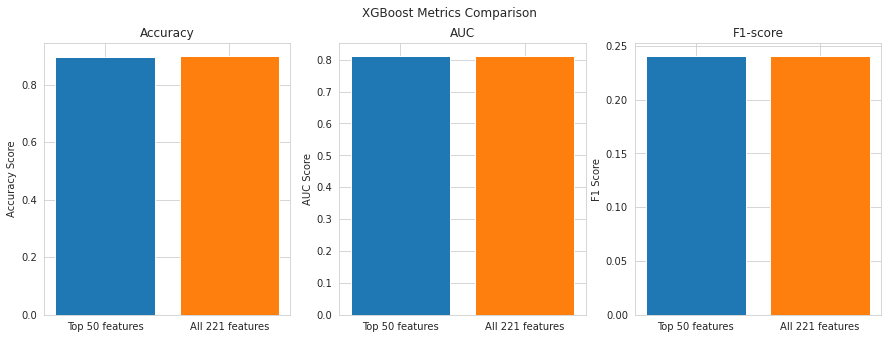

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

ax[0].bar("Top 50 features", top_xgb_model_accuracy)
ax[0].bar("All 221 features", xgb_model_accuracy)
ax[0].set_ylabel("Accuracy Score")
ax[0].set_title("Accuracy")

ax[1].bar("Top 50 features", top_xgb_model_auc)
ax[1].bar("All 221 features", xgb_model_auc)
ax[1].set_ylabel("AUC Score")
ax[1].set_title("AUC")

ax[2].bar("Top 50 features", top_xgb_model_f1)
ax[2].bar("All 221 features", xgb_model_f1)
ax[2].set_ylabel("F1 Score")
ax[2].set_title("F1-score")
plt.suptitle("XGBoost Metrics Comparison")
plt.savefig("XGBoostMetricsComparison.png")
plt.show()

Thus there seems to be no major difference in metrics  by choosing the top 50 features. This could be due to the low Permutation Importance of the rest of the predictors.

Hence we can reduce the model's computation complexity by choosing these 50 features

# Interpretation

In [ ]:
from prettytable import PrettyTable

In [ ]:
pt = PrettyTable()
pt.field_names = ["Strategy","Accuracy","F1 Score","Recall","AUC score"]
pt.add_row(["Logistic Regression - with class imbalanced dataset",round(log_model_accuracy,3),round(log_model_f1,3),round( log_model_recall,3),round(log_model_auc,3)])
pt.add_row(["Logistic Regression - with class balanced dataset",round(o_log_model_accuracy,3),round(o_log_model_f1,3),round( o_log_model_recall,3),round( o_log_model_auc,3)])
pt.add_row(["Random Forest Classifier- with class balanced dataset",round(rf_model_accuracy,3),round(rf_model_f1,3),round(rf_model_recall,3),round( rf_model_auc,3)])
pt.add_row(["XGBoost Classifier - with class balanced dataset",round( xgb_model_accuracy,3),round( xgb_model_f1,3),round( xgb_model_recall,3),round( xgb_model_auc,3)])
print(pt)

+-------------------------------------------------------+----------+----------+--------+-----------+
|                        Strategy                       | Accuracy | F1 Score | Recall | AUC score |
+-------------------------------------------------------+----------+----------+--------+-----------+
|  Logistic Regression - with class imbalanced dataset  |   0.96   |   0.01   | 0.005  |   0.793   |
|   Logistic Regression - with class balanced dataset   |  0.723   |  0.171   | 0.721  |   0.778   |
| Random Forest Classifier- with class balanced dataset |  0.891   |  0.236   | 0.426  |   0.803   |
|    XGBoost Classifier - with class balanced dataset   |  0.899   |  0.241   | 0.403  |   0.811   |
+-------------------------------------------------------+----------+----------+--------+-----------+


From the above table,  we can infer that accuracy isn't the best parameter to evaluate the model performance. Since accuracy doesn't factor in class imbalances.

Better metrics to evaluate the model are the f1-score and AUC score. From these metrics we can see that the **XGBoost classifier** has performed the best followed by **Random Forest** and **Logistic Regresion** as also supported in the ROC curve below.

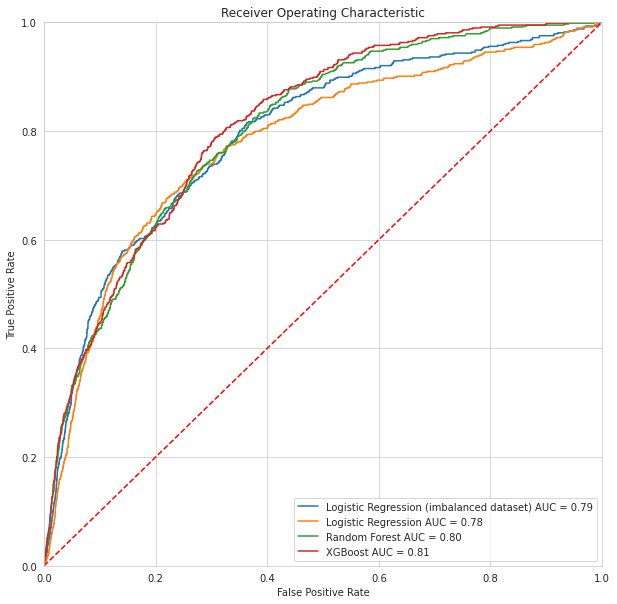

In [ ]:
## ROC curve plot of models
plt.rcParams['font.size'] = '10'
plt.figure(figsize=(10,10))

model_dict =  {
    "Logistic Regression (imbalanced dataset)": log_model,
    "Logistic Regression" : o_log_model,
    "Random Forest" : rf_model,
    "XGBoost" : XGB_clf
}

for model_name, model_obj in model_dict.items():
  probs = model_obj.predict_proba(X_test)
  preds = probs[:,1]
  fpr, tpr, threshold = roc_curve(y_test, preds)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, label = f'{model_name} AUC = %0.2f' % roc_auc)

plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("ROC_Curve.png")
plt.show()

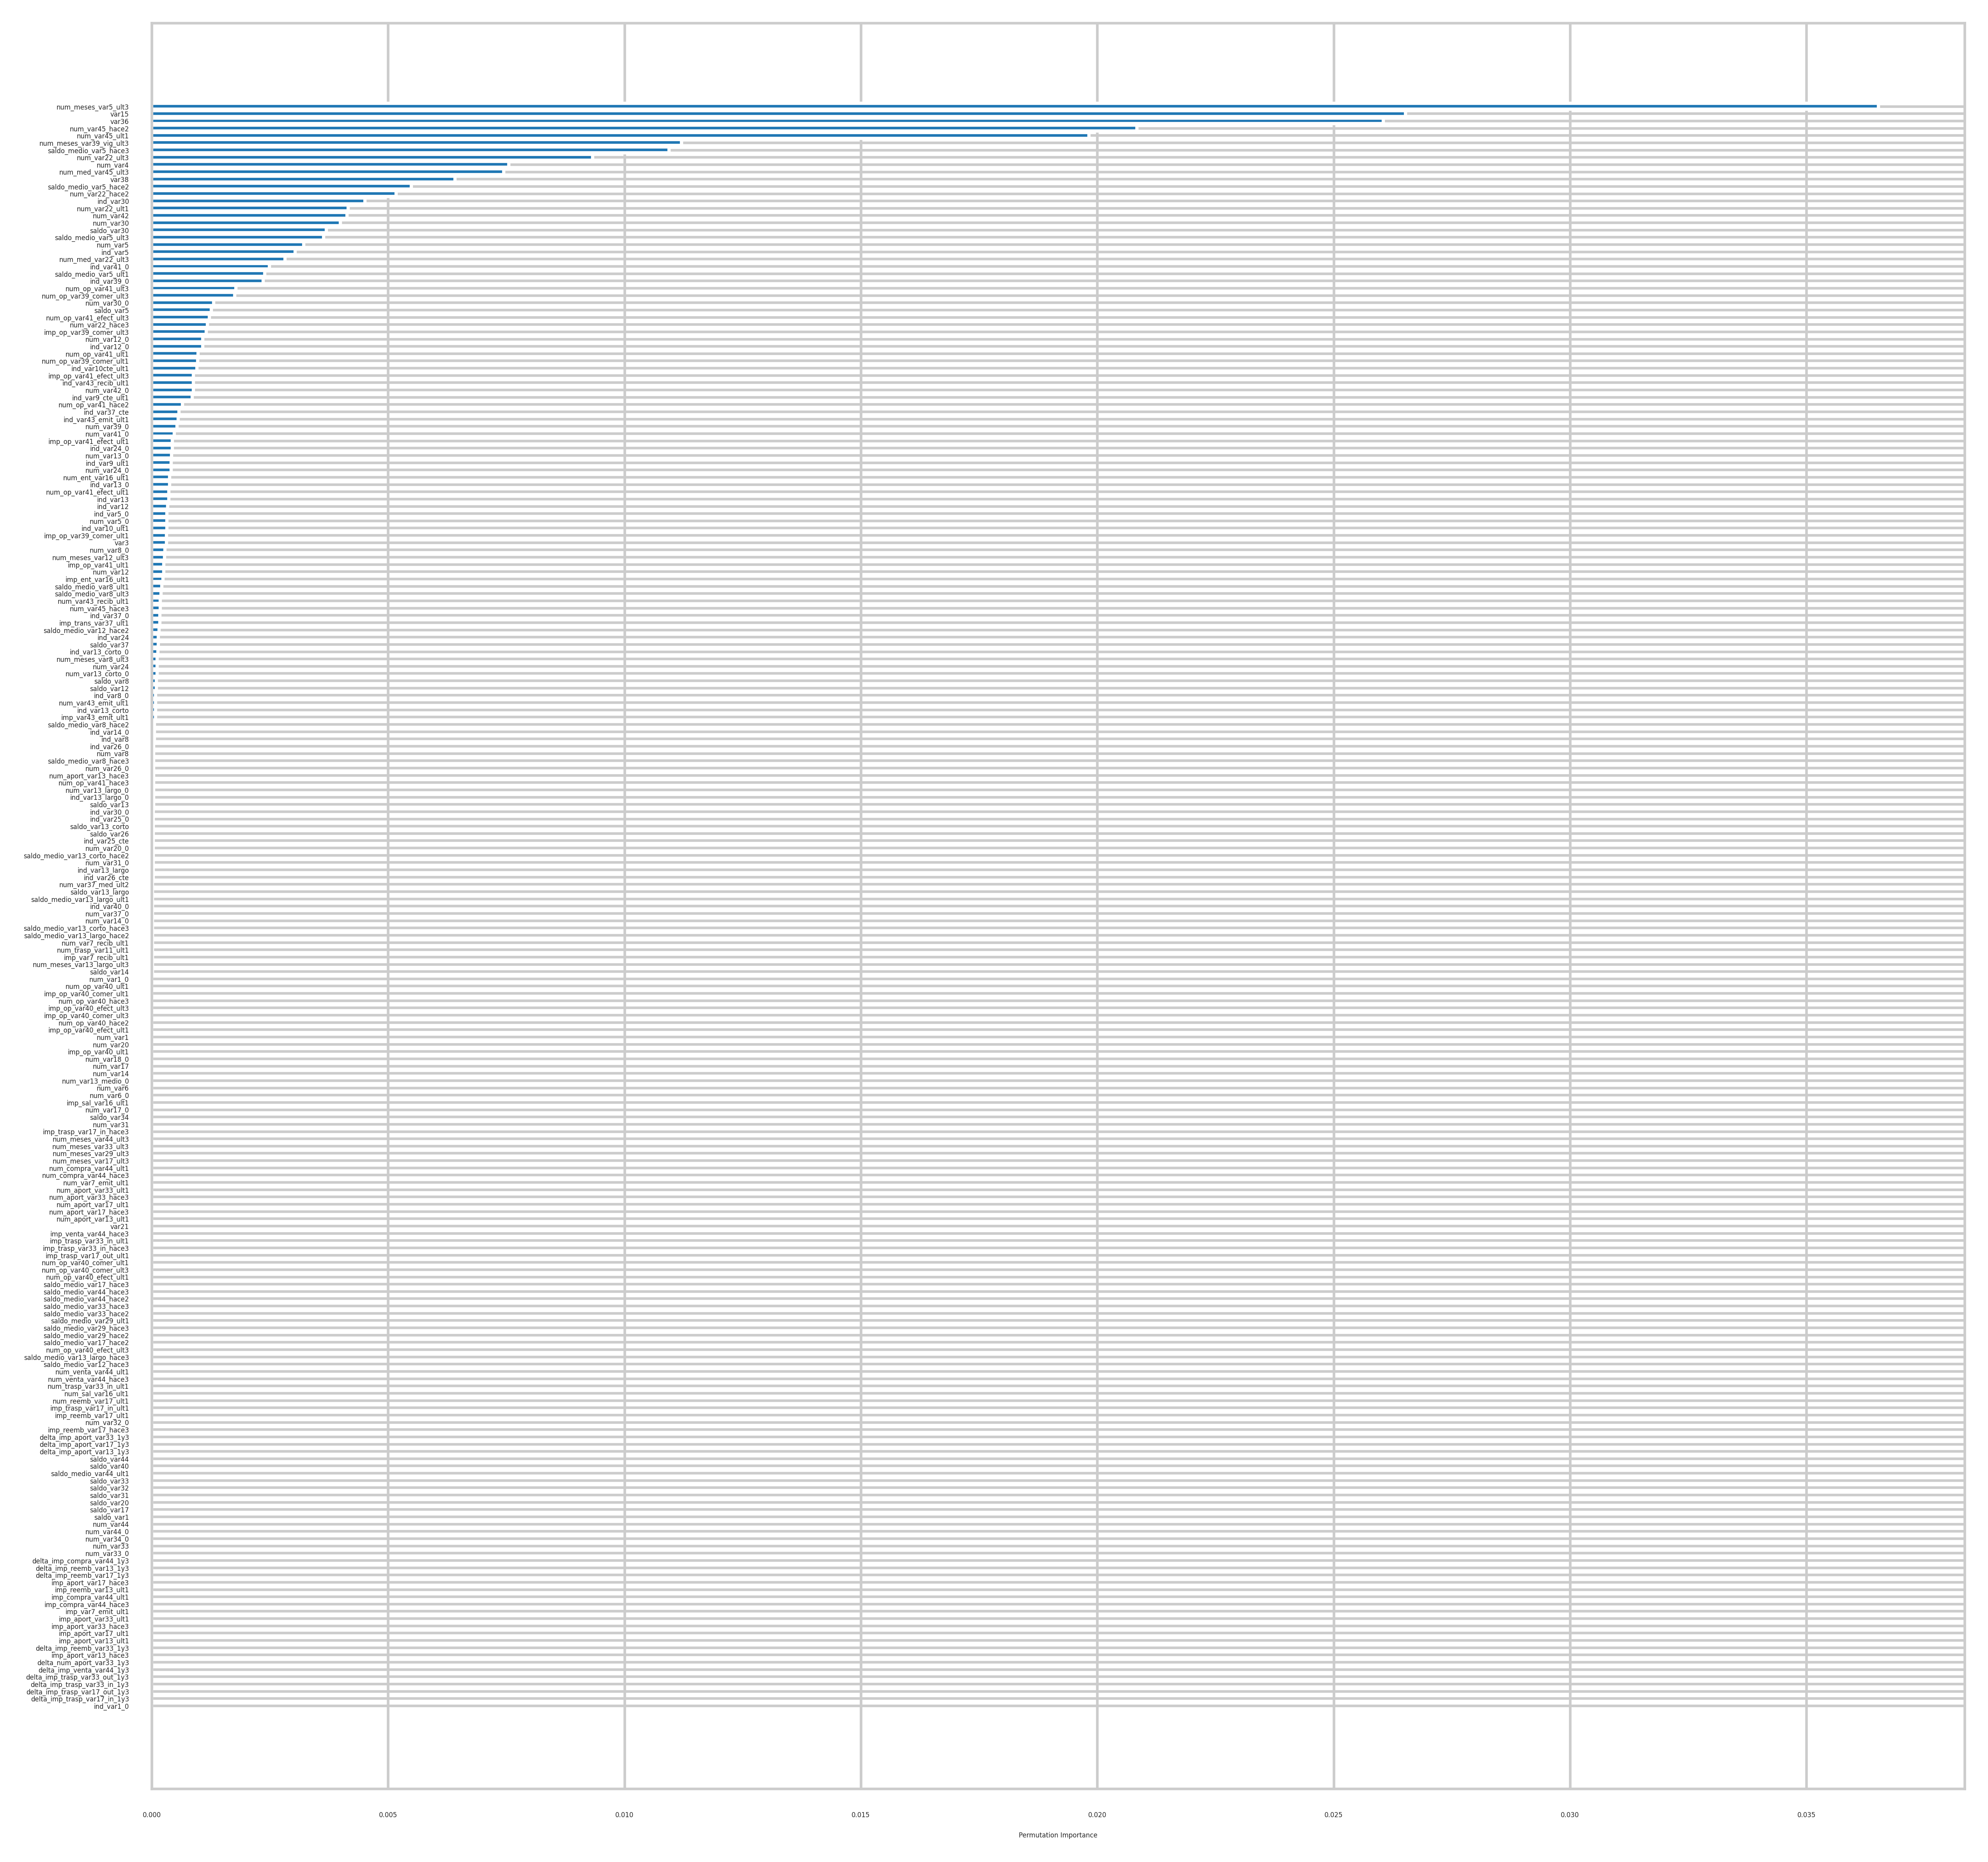

In [ ]:
## Permutation Importance of all 221 features
plt.rcParams['font.size'] = '2'
plt.figure(figsize=(10,10), dpi=600)
sorted_idx = np.absolute(perm_importance.importances_mean).argsort()
plt.barh(X_test.columns[sorted_idx], np.absolute(perm_importance.importances_mean[sorted_idx]))
plt.xlabel("Permutation Importance")
plt.savefig('Permutation_Importance_all.png', dpi=800)
plt.show()

In [ ]:
coeffs = np.absolute(perm_importance.importances_mean[sorted_idx])
print(f"{coeffs[np.where(coeffs == 0)].size} features have zero importance")
print(f"{coeffs[np.where(coeffs > 0.01)].size} features have importance greater than 0.01")

101 features have zero importance
7 features have importance greater than 0.01


The Above plot shows the feature importance derived by **Permutation Importance** using Random Forest Model.
Even after removing 150 features from total 371 features using feature preprocessing, 91 features still have an importance of 0 in the model and only 7 features have an Permutation Importance of >0.01

# Conclusion

Accuracy isn't the best parameter to evaluate the model performance. Since accuracy doesn't factor in class imbalances.

Better metrics to evaluate the model are the f1-score and AUC score. From these metrics we can see that the XGBoost classifier has performed the best followed by Random Forest and Logistic Regresion.


**XGBoost Classifier**

Accuracy =  0.899 

F1 Score = 0.241

Recall = 0.403

AUC score = 0.811


# Submission File

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/Univ.AI/test.csv')


In [ ]:
test_data.shape , train_data.shape

((75818, 370), (76020, 371))

In [ ]:
submission_df = test_data[["ID"]]

In [ ]:
test_data = test_data.drop("ID", axis=1)

# Drop Constant Features
test_data = test_data.drop(const_col, axis = 1)


In [ ]:
# Drop Duplicate columns
test_data = duplicates.transform(test_data)

In [ ]:
# Split categorical and numerical columns
test_data_cat = test_data[categorical_columns]

test_data_num = test_data.drop(categorical_columns, axis=1)

In [ ]:
# Drop Correlated data
test_data_num = correlated.transform(test_data_num)

In [ ]:
# Scale numerical columns
test_num = scaler.transform(test_data_num)
test_data_num = pd.DataFrame(test_num, columns=test_data_num.columns)


In [ ]:
# Join categorical and numerical columns
data = pd.concat([test_data_cat.reset_index(drop=True), test_data_num.reset_index(drop=True)], axis=1)


In [ ]:
data = data.drop(sparse_columns, axis=1)

In [ ]:
# Predict on XGBoost model
pred = XGB_clf.predict(data)

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Save Prediction as TARGET column
submission_df["TARGET"]=pred

In [ ]:
proba = XGB_clf.predict_proba(data)

In [ ]:
proba.shape

(75818, 2)

In [ ]:
# Save Probability as "Unsatisfied Customer Probability" column
submission_df["Unsatisfied Customer Probability"] = proba[:,1]

In [ ]:
submission_df.head()

,ID,TARGET,Unsatisfied Customer Probability
0,2,0,0.235417
1,5,0,0.082970
2,6,0,0.002582
3,7,0,0.022919
4,9,0,0.005867


In [ ]:
submission_df.to_csv("Submission.csv")